In [128]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
import seaborn as sb

In [129]:
data = pd.read_csv('data/exp1/MNIST Numbers_FLEX2_214398_2024.04.01T11.18.40+02.00.md.bp.csv', skiprows=1)
markers = pd.read_csv('data/exp1/MNIST Numbers_FLEX2_214398_2024.04.01T11.18.40+02.00_intervalMarker.csv')
print()
markers = markers[['type','duration','marker_id']]
markers = markers[markers['type'].isin( ['eyesopen_element_n0bp', 'eyesclose_element_5sw8',
                                      '0','1','2','3','4', '5','6', '7','8', '9'])]

columns_to_look = ['EEG.Fp1',	'EEG.AF3',	'EEG.F3',	'EEG.FC1'	,'EEG.C3'	,'EEG.FC3'	,'EEG.T7'	,'EEG.CP5',	'EEG.CP1'	,'EEG.P1'	,'EEG.P7'	,'EEG.P9',	'EEG.PO3'	,'EEG.O1'	,'EEG.O9',	'EEG.POz',	'EEG.Oz',	'EEG.O10',	'EEG.O2',	'EEG.PO4'	,'EEG.P10',	'EEG.P8',	'EEG.P2','EEG.CP2',	'EEG.CP6'	,'EEG.T8',	'EEG.FC4',	'EEG.C4',	'EEG.FC2',	'EEG.F4', 'EEG.AF4',	'EEG.Fp2']

# Given string containing column names separated by tabs
column_names_extra = [col for col in data.columns if col.startswith("POW")]


In [ ]:
for i in range(1,7):
    data = pd.read_csv("data/exp{}/data.csv".format(i), skiprows=1)
    markers = pd.read_csv("data/exp{}/intervalMarker.csv".format(i))
    markers = markers[['type','duration','marker_id']]
    markers = markers[markers['type'].isin( ['eyesopen_element_n0bp', 'eyesclose_element_5sw8',
                                          '0','1','2','3','4', '5','6', '7','8', '9'])]

In [154]:
# Compute baseline
baseline_marker_closed_eyes = markers[markers['type'] == 'eyesclose_element_5sw8']

index1 = data[data['MarkerIndex'] == baseline_marker_closed_eyes['marker_id'].values[0]].index[0]
index2 = data[data['MarkerIndex'] == -baseline_marker_closed_eyes['marker_id'].values[0]].index[0]
baseline_df = data.iloc[index1:index2+1]
filtered_df_channels = baseline_df[columns_to_look]
baseline_closed = np.mean(filtered_df_channels, axis=0)
baseline_closed = baseline_closed[columns_to_look]

baseline_marker_open_eyes = markers[markers['type'] == 'eyesopen_element_n0bp']

index1 = data[data['MarkerIndex'] == baseline_marker_closed_eyes['marker_id'].values[0]].index[0]
index2 = data[data['MarkerIndex'] == -baseline_marker_closed_eyes['marker_id'].values[0]].index[0]
baseline_df = data.iloc[index1:index2+1]
filtered_df_channels = baseline_df[columns_to_look]
baseline_open = np.mean(filtered_df_channels, axis=0)
baseline_open = baseline_open[columns_to_look]

In [171]:
TRIM_FIRST = 200
TRIM_LAST = 200

all_dfs = []
for index,mark in tqdm(markers.sort_values('type', ascending=False).iterrows(),total=len(markers), desc="Processing rows"):
    if mark['type'] != 'eyesclose_element_5sw8' and mark['marker_id'] != 10: # first 2 is ID 10
        index1 = data[data['MarkerIndex'] == mark['marker_id']].index[0]
        index2 = data[data['MarkerIndex'] == -mark['marker_id']].index[0]
        filtered_df = data.iloc[index1:index2+1]
        duration = data.loc[index2,'Timestamp'] - data.loc[index1,'Timestamp']
        assert round(duration,1) == round(mark['duration'],1)
        filtered_df_channels = filtered_df[columns_to_look]
        filtered_df_channels = filtered_df_channels.iloc[TRIM_FIRST:-TRIM_LAST]
        filtered_df_alpha_beta = filtered_df[column_names_extra].dropna()
        filtered_df_alpha_beta.to_csv('data/processed/alphaBeta/{}_{}.csv'.
                                    format(mark['type'], mark['marker_id']))
        filtered_df_channels.to_csv('data/processed/channels/{}_{}.csv'.
                                    format(mark['type'], mark['marker_id']))
        filtered_df_channels['label'] = mark['type']
        filtered_df_channels_baselined = filtered_df_channels-baseline_closed.T
        filtered_df_channels_baselined['label'] = mark['type']
        filtered_df_channels_baselined.to_csv('data/normalized_by_baseline/channels/{}_{}.csv'.
                                    format(mark['type'], mark['marker_id']))

        all_dfs.append(filtered_df_channels_baselined)
total_data = pd.concat(all_dfs, ignore_index=True)

Processing rows: 100%|██████████| 56/56 [00:02<00:00, 27.59it/s]


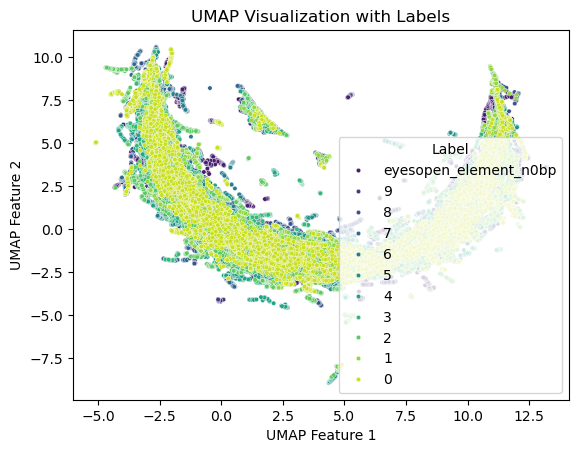

In [170]:
import umap
import matplotlib.pyplot as plt
import seaborn as sb

reducer = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    metric="manhattan", # cosine,correlation,jaccard,dice,canberra, minkowski,manhattan, euclidean
    min_dist=0.001,
)
umap_features = reducer.fit_transform(total_data[columns_to_look])
umap_df = pd.DataFrame(umap_features, columns=['UMAP Feature 1', 'UMAP Feature 2'])
umap_df['label'] = total_data['label']
# Plot the UMAP features
sb.scatterplot(data=umap_df, x='UMAP Feature 1', y='UMAP Feature 2', hue='label', palette='viridis', s=10)
plt.title('UMAP Visualization with Labels')
plt.xlabel('UMAP Feature 1')
plt.ylabel('UMAP Feature 2')
plt.legend(title='Label')